In [1]:
import numpy as np
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [141]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [142]:
peak_rate, kernel_width = 150, 20

In [143]:
T_rend = 600 # Each rendition
N_rend = 35 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


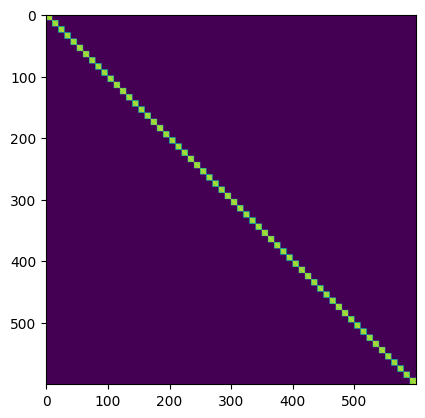

In [144]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
N_shared_channels = 10
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [145]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [146]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [147]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.2, 0.6]) / 3
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
# c = 1
# JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.25, 0.9])
# sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=True) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=True) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=True) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=True) / np.sqrt(NI)
J0_mean = JEE0 / np.sqrt(NE) * c

In [10]:
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [66]:
w0_mean, w0_std, cW = 2/N_HVC, 0/N_HVC, 0.05
w_inh, wI = w0_mean*cW, 0.0
tauE, tauI, dt = 40, 10, 1

net = EINetRecPlasticity(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
                         JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                         w_inh=w_inh, wI=wI, w0_std=w0_std, cW=cW)

100%|███████████████████████████████████████| 999/999 [00:00<00:00, 3387.58it/s]


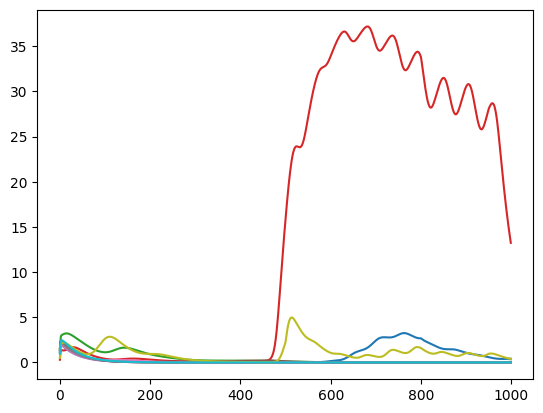

In [67]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
aux = [np.zeros_like(rH[:1000])+rH[:1000].mean(axis=1)[:,None], 
       np.zeros_like(aud[:1000])+aud[:1000].mean(axis=1)[:,None]]
_ = net.sim(rE0, rI0, *aux, [], 1000, dt, 0)
rE, rI, _, _, hE = _
plt.plot(rE[:1000,:10]);

In [13]:
from numba import njit, void, f8, i4
@njit(void(f8[:], f8[:], f8[:], i4[:], i4[:]))
def outer(out, post, pre, indptr, indices):
    for i in range(len(pre)):
        # range in .data for the i-th col
        p, q = indptr[i], indptr[i+1] 
        out[p:q] = (post[indices[p:q]] - 1) * pre[i]

def bilin_hebb(net, aiv_post, aiv_pre, hvc, lr, J0_mean, tauW):
    # lr < 0, anti-Hebbian
    #### Comment off to enable HVC->E plasticity as well ####
    # if issparse(net.W):
    #     aux = np.zeros(net.W.data.shape)
    #     outer(aux, aiv_post, hvc, net.W.indptr, net.W.indices)
    #     dW = lr * aux - (net.W.data - net.w0_mean)
    #     net.W.data = np.clip(net.W.data + dW / tauW, a_min=0, a_max=None)
    # else:
    #     aux = (aiv_post[:,None] - 1) * hvc[:,None]
    #     dW = lr * (aiv_post[:,None] - 1) * hvc[:,None] - (net.W - net.w0_mean)
    #     net.W = np.clip(net.W + dW / tauW, a_min=1e-10, a_max=None)
    ####
    if issparse(net.JEE):
        aux = np.zeros(net.JEE.data.shape)
        outer(aux, aiv_post, aiv_pre, net.JEE.indptr, net.JEE.indices)
        dW = lr * aux - (net.JEE.data - J0_mean)
        net.JEE.data = np.clip(net.JEE.data + dW / tauW, a_min=1e-10, a_max=None)
    else:
        aux = (aiv_post[:,None] - 1) * aiv_pre[None,:]
        dW = lr * aux - (net.JEE - J0_mean)
        net.JEE = np.clip(net.JEE + dW / tauW, a_min=1e-10, a_max=None)

In [14]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
_ = net.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
            lr=-4e-1, asyn=10, J0_mean=J0_mean, tauW=1e5)
rE, rI, Ws, mean_HVC_input, hE = _
if issparse(Ws[0]):
    Ws = [_.toarray() for _ in Ws]

100%|████████████████████████████████████| 21499/21499 [00:21<00:00, 988.97it/s]


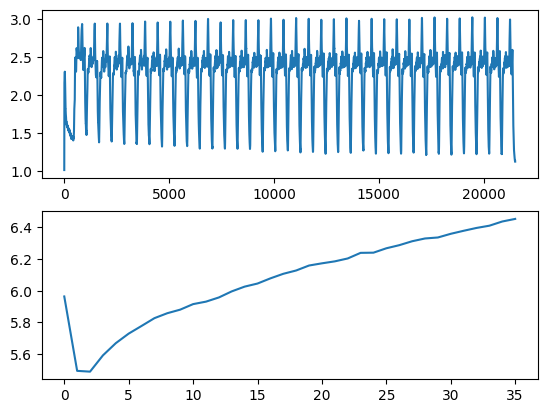

In [15]:
fig, ax = plt.subplots(2)
ax[0].plot(rE.mean(axis=-1))
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws])

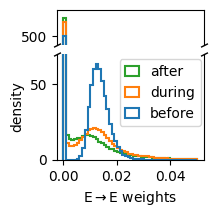

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(2, 2), height_ratios=[1, 3])
fig.subplots_adjust(hspace=0.05)
hist = [Ws[_].flatten() for _ in (0, 5, -1)]
for i in range(2):
    ax[i].hist(hist, bins=50, density=True, histtype='step', range=(0, 0.05), lw=1.5,
               label=('before', 'during', 'after'))
ax[0].set(ylim=[400, 800], yticks=[500], xticks=[])
ax[1].set(ylim=[0, 70], yticks=[0, 50], ylabel='density', xlabel=r'E$\to$E weights')
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)
ax[1].legend(bbox_to_anchor=(0.38, 0.25), ncols=1, handlelength=1)
fig.savefig('svg/EI_rec_weight_dist_over_learning.svg', transparent=True)

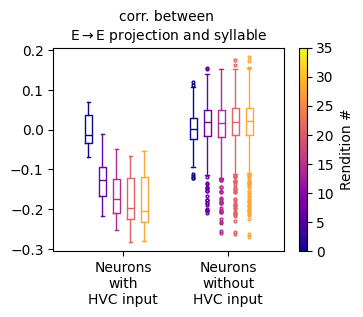

In [16]:
J_corrs = [correlation(_.T, syl) for _ in Ws]
cmap = plt.get_cmap('plasma')
p, q = 0, 1 # syl idx and hvc idx
idx = [0, 5, 10, 20, N_rend-1] # rendition idx
filt = np.where(net.W.toarray() != 0)
idx_sig = filt[0][filt[1]==q]
idx_bg = [i for i in range(NE) if i not in idx_sig]
fig, ax = plt.subplots(1, sharey='all', figsize=(3.5, 3))
for i, j in enumerate(idx):
    color = cmap(i/len(idx))
    sig = J_corrs[i][idx_sig,p]
    bg = J_corrs[i][idx_bg,p]
    ax.boxplot([sig, bg], positions=[i/len(idx), 1.5+i/len(idx)],
               widths=0.5/len(idx), flierprops=dict(ms=2, mec=color), 
               boxprops=dict(color=color), capprops=dict(color=color),
               whiskerprops=dict(color=color), medianprops=dict(color=color))
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=N_rend))
fig.colorbar(sm, ax=ax, aspect=25, label='Rendition #')

ax.set(xticks=[0.5, 2], xticklabels=['Neurons\nwith\nHVC input', 'Neurons\nwithout\nHVC input'])
ax.set_title('pattern similarity between\nE$\\to$E synaptic weights and tutor song', fontsize=10)
fig.tight_layout(pad=0.1)
fig.savefig('svg/EI_rec_train_result.svg')

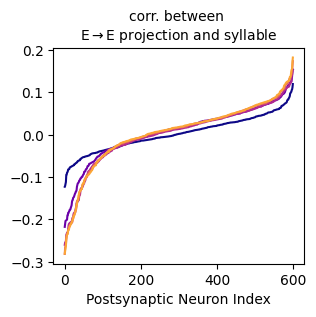

In [17]:
cmap = plt.get_cmap('plasma')
p, q = 0, 1 # syl idx and hvc idx
idx = [0, 5, 10, 20, -1]
filt = np.where(net.W.toarray() != 0)
fig, ax = plt.subplots(1, sharey='all', figsize=(3, 3))
for i, j in enumerate(idx):
    color = cmap(i/len(idx))
    ax.plot(np.sort(J_corrs[i][:,p]), c=color)
ax.set(xlabel='Postsynaptic Neuron Index')
ax.set_title('corr. between \n' + r'E$\to$E projection and syllable', fontsize=10)
fig.tight_layout(pad=0.1)

## Test Model with Different Scenarios

In [19]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [20]:
exp = Experiment(net, rH, syl, noise=1, T_test=T_burn+T_rend, 
                 t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
pert_mean = np.ones(NE)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert_args = [(pert_mean, pert_cov, 0)]
test_codes = ('correct', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n')
tests_all = exp.sim_multi(test_codes, if_sing, pert_args * len(test_codes))

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 3571.61it/s]


In [21]:
rE_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['rE']]
syl_block_avgs = block_apply(syl, K=N_shared_channels, func=np.mean)
bos_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['bos']]

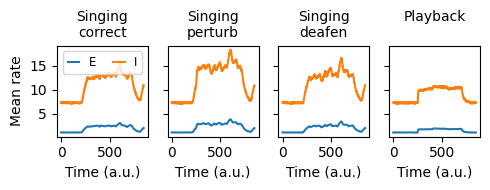

In [22]:
ti, tj = T_burn//2, T_burn+T_rend
fig, ax = plot_tests_mean(tests_all['rE'], tests_all['rI'], test_names, ti, tj)

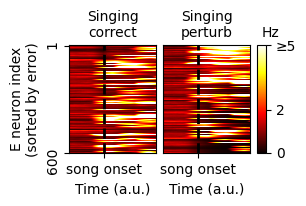

In [23]:
fig, ax = plot_raster_cmp_syl_dsyl(tests_all['rE'][0], tests_all['rE'][2], syl[0], 
                                   tests_all['bos'][2][0]-syl[0], 
                                   tsyl_start[0,0], tsyl_end[0,0], 
                                   figsize=(3, 2), plot_z=False, th=5)
fig.savefig('svg/err_response_EI_rec.svg', transparent=True)

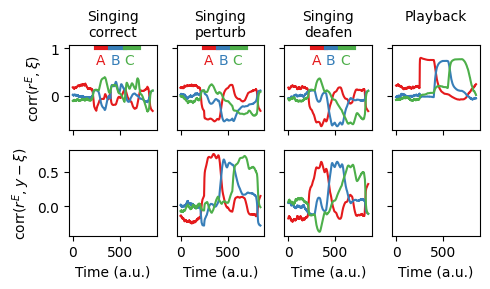

In [24]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs(rE_block_avgs, bos_block_avgs, syl_block_avgs, test_names,
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1)

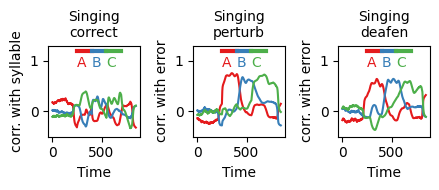

In [25]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
# Do not need to show playback
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs_simple(rE_block_avgs[:-1], bos_block_avgs[:-1], 
                                  syl_block_avgs, test_names[:-1],
                                  ti, tj, tid_perturb_input=(1, 2), 
                                  syl_order=so, y=1.2)
fig.savefig('svg/corr_EI_rec.svg', transparent=True)

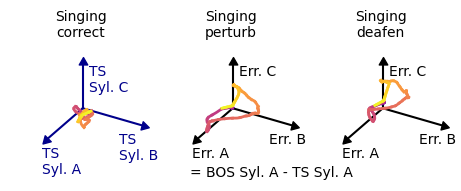

In [26]:
_ = bos_block_avgs[1] - syl_block_avgs
syl_norm = np.linalg.norm(syl_block_avgs, axis=1)
proj = [rE_block_avgs[0] @ syl_block_avgs.T / syl_norm**2,
         rE_block_avgs[1] @ _.T / np.linalg.norm(_, axis=1)**2,
         -rE_block_avgs[2] @ syl_block_avgs.T / syl_norm**2]
l1, l2 = 'TS\nSyl. %s', 'Err. %s'
dt = 10
cmap = plt.get_cmap('plasma')
fig, ax = plt.subplots(1, 3, figsize=(4.5, 2), subplot_kw={'projection':'3d'}, 
                       constrained_layout=True)
for i, (t, l) in enumerate(zip(test_names[:-1], (l1, l2, l2))):
    ax[i].view_init(elev=30, azim=30, roll=0)
    ax[i].set_box_aspect(aspect=None, zoom=1.5)
    c = 'k' if i > 0 else 'darkblue'
    ax[i].plot([0,1], [0,0], [0,0], c=c)
    ax[i].scatter(1, 0, 0, marker=(3,0,15), s=50, c=c)
    ax[i].text(1.1, 0, -0.05, l % 'A', ha='left', va='top', color=c)
    ax[i].plot([0,0], [0,1], [0,0], c=c)
    ax[i].scatter(0, 1, 0, marker=(3,0,15), s=50, c=c)
    ax[i].text(0, 0.6, -0.3, l % 'B', ha='left', va='top', color=c)
    ax[i].plot([0,0], [0,0], [0,1], c=c)
    ax[i].scatter(0, 0, 1, marker=(3,0,0), s=50, c=c)
    ax[i].text(0, 0.1, 1.0, l % 'C', ha='left', va='top', color=c)
    ax[i].grid(False)
    ax[i].set(xlim=[-1,1],ylim=[-1,1],zlim=[-1,1])
    ax[i].set_axis_off()
    ax[i].set_title(t, fontsize=10, va='top')
    for j in range(0, proj[i].shape[0]-1, dt):
        c = cmap(j/proj[i].shape[0])
        ax[i].plot(*(proj[i][j:j+dt+1].T), color=c, lw=2)
fig.text(0.41, 0.2, '= BOS Syl. A - TS Syl. A', ha='left', va='top')
fig.savefig('svg/traj_EI_rec.svg', transparent=True)

344 256
97 53


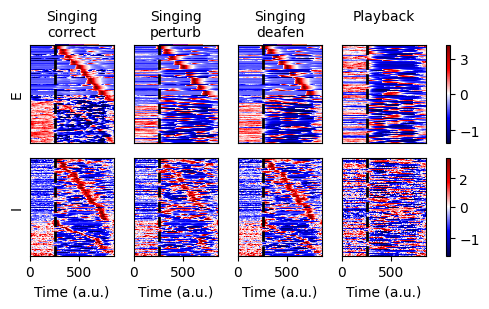

In [27]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
fig, ax = plot_tests_raster(tests_all, test_names, 
                            ti, tj, T_burn, plot_inh=True, syl_order=so)
fig.savefig('svg/raster_EI_rec.svg')

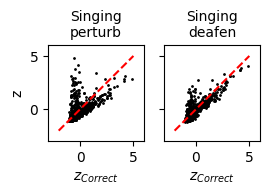

In [28]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_ctrl_vs_nonctrl(tests_all['rE'][:-1], test_names[:-1], ti, tj)
# fig, ax = plot_ctrl_vs_nonctrl(rE_block_avgs[:-1], test_names[:-1], ti, tj)
fig.savefig('svg/joint_dist_c_vs_nc_EI_rec.svg', transparent=True)

[(-1.0, 1.0)]

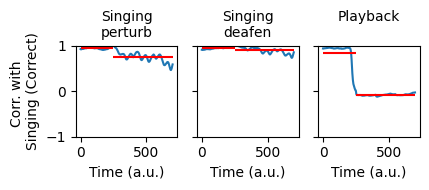

In [29]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all['rE'], test_names, ti, tj, T_burn)
# fig, ax = plot_corr_ctrl_nonctrl(rE_block_avgs, test_names, ti, tj, T_burn)
ax[0].set(ylim=[-1, 1])

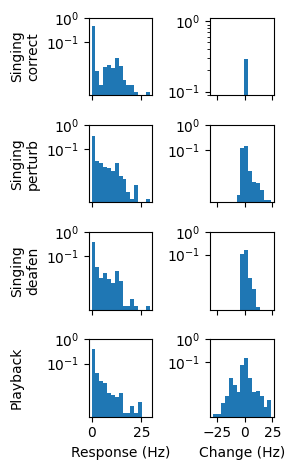

In [30]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all['rE'], test_names, tests_all['rE'][0], ti, tj)
# fig, ax = plot_rate_and_change_dists(rE_block_avgs, test_names, rE_block_avgs[0], ti, tj)

In [31]:
net_naive = EINetRecPlasticity(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
                               JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                               w_inh=w_inh, wI=wI, w0_std=w0_std, cW=cW)
net_naive.W = net.W.copy()
exp_naive = Experiment(net_naive, rH, syl, noise=1, T_test=T_burn+T_rend, 
                       t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
playback_naive = exp_naive.sim_multi(['correct'], [False])

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 3428.65it/s]


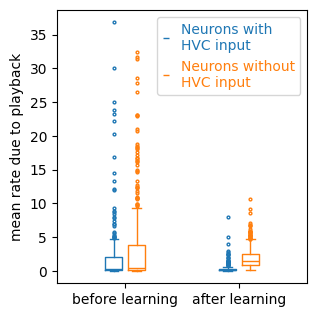

In [32]:
filt = np.where(net.W.toarray() != 0)
# idx_sig = filt[0][(filt[1]==1)|(filt[1]==2)]
idx_sig = np.unique(filt[0])
idx_bg = [i for i in range(NE) if i not in idx_sig]

rE_sig = tests_all['rE'][-1][:,idx_sig].mean(axis=0)
rE_bg = tests_all['rE'][-1][:,idx_bg].mean(axis=0)
rE_pb_sig = playback_naive['rE'][0][:,idx_sig].mean(axis=0)
rE_pb_bg = playback_naive['rE'][0][:,idx_bg].mean(axis=0)

xticks = ['before learning', 'after learning']

fig, ax = plt.subplots(1, figsize=(3, 3))
for j, (k, l) in enumerate(zip(([rE_pb_sig, rE_sig], [rE_pb_bg, rE_bg]), ('with', 'without'))):
    color = 'C%d' % j
    ax.boxplot(k, positions=[0+j*0.2, 1+j*0.2], label='Neurons '+l+'\nHVC input',
               flierprops=dict(ms=2, mec=color), 
               boxprops=dict(color=color), capprops=dict(color=color),
               whiskerprops=dict(color=color), medianprops=dict(color=color))
ax.legend(labelcolor=['C0', 'C1'], handlelength=0.5)
ax.set_xticks(np.arange(len(xticks))+0.1, xticks)
ax.set(ylabel='mean rate due to playback')
fig.tight_layout(pad=0.1)

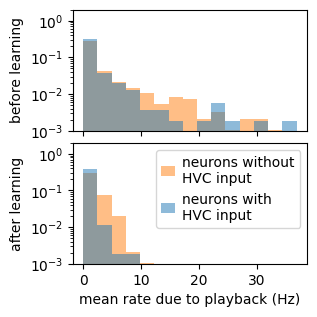

In [33]:
filt = np.where(net.W.toarray() != 0)
# idx_sig = filt[0][(filt[1]==1)|(filt[1]==2)]
idx_sig = np.unique(filt[0])
idx_bg = [i for i in range(NE) if i not in idx_sig]

rE_af_sig = tests_all['rE'][-1][:,idx_sig].mean(axis=0)
rE_af_bg = tests_all['rE'][-1][:,idx_bg].mean(axis=0)
rE_bf_sig = playback_naive['rE'][0][:,idx_sig].mean(axis=0)
rE_bf_bg = playback_naive['rE'][0][:,idx_bg].mean(axis=0)

title = ['before learning', 'after learning']
hist_max = max(map(np.max, (rE_bf_sig, rE_bf_bg, rE_af_sig, rE_af_bg)))

fig, ax = plt.subplots(2, sharex='all', figsize=(3, 3))
for j, k in enumerate(([rE_bf_sig, rE_bf_bg], [rE_af_sig, rE_af_bg])):
    ax[j].hist(k, range=(0, hist_max), bins=15, histtype='stepfilled', density=True,
               alpha=0.5, label=['neurons with\nHVC input', 'neurons without\nHVC input'])
    ax[j].set(yscale='log', ylim=[0.001, 2], ylabel=title[j])
ax[1].legend(handlelength=1, handletextpad=0.5)
ax[1].set(xlabel='mean rate due to playback (Hz)')
fig.tight_layout(pad=0.1)
fig.savefig('svg/EI_rec_pb_mean_rate_before_after.svg')

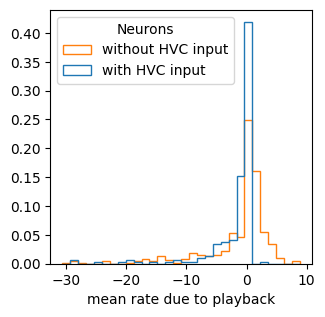

In [34]:
filt = np.where(net.W.toarray() != 0)
# idx_sig = filt[0][(filt[1]==1)|(filt[1]==2)]
idx_sig = np.unique(filt[0])
idx_bg = [i for i in range(NE) if i not in idx_sig]

rE_af_sig = tests_all['rE'][-1][:,idx_sig].mean(axis=0)
rE_af_bg = tests_all['rE'][-1][:,idx_bg].mean(axis=0)
rE_bf_sig = playback_naive['rE'][0][:,idx_sig].mean(axis=0)
rE_bf_bg = playback_naive['rE'][0][:,idx_bg].mean(axis=0)

title = ['before learning', 'after learning']

fig, ax = plt.subplots(1, sharex='all', figsize=(3, 3))
ax.hist([rE_af_sig - rE_bf_sig, rE_af_bg - rE_bf_bg],  
        bins=30, histtype='step', density=True,
        label=['with HVC input', 'without HVC input'])
ax.legend(title='Neurons')
ax.set(xlabel='mean rate due to playback')
fig.tight_layout(pad=0.1)